# MLB Game Prediction
Parker Jackson

## Goal:
- to predict the Outcome of an MLB game, whether the home team wins or not

using MLB-StatsAPI (https://pypi.org/project/MLB-StatsAPI/)  
Data uploaded at https://www.kaggle.com/datasets/parkerjackson17/mlb-2015-thru-2025

## Features:
All features are repeated for both Home and Away team, unless it doesn't make sense, i.e. Venue and Wind Speed.

### Game Context

#### Location
- venue_id (categorical)
- park_factor_runs (continuous, ~1)
- park_factor_hr (continuous, ~1)

#### Weather
- temperature (continuous)
- wind_speed (unsigned continuous)
- condition (categorical)

#### Schedule/Travel
- rest days (non-negative integers)
- games in last 7 (non-negative integers, <= 7)

### Team Strength  
- win percentage (non-negative continuous)
- run differential (continuous)

### Lineup Strength
- OPS (on-base % + slugging %) (non-negative, continuous)
- batting average (non-negative, continuous, <= 1)
- starting pitcher ERA (earned run average (9 innings)) (continuous, non-negative)
- starting pitcher WHIP (walks, hits per inning pitched) (continuous, non-negative)

## Outcome

home win (binary output): 
- 1: home team wins
- 0: home team loses

## Imports/Setup

In [312]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [313]:
df = pd.read_csv("data/mlb_2015_2025_dataset.csv", index_col=0)

# optimize and change data types
df['date'] = pd.to_datetime(df['date'])                                                 # ensure dates are proper type
df = df[df['condition'] != 'Unknown']
df["condition"] = df["condition"].astype("category")                                    # weather conditions --> category
df["home_team"] = df["home_team"].astype("category")                                    # team id's and venue id are not numeric --> category
df["away_team"] = df["away_team"].astype("category")
df["venue_id"] = df["venue_id"].astype("category")
int_cols = df.select_dtypes(include=["int"])
df[int_cols.columns] = df[int_cols.columns].apply(pd.to_numeric, downcast="integer")    # downcast ints
float_cols = df.select_dtypes(include=["float"])
df[float_cols.columns] = df[float_cols.columns].apply(pd.to_numeric, downcast="float")  # downcast floats

# Load and merge park factors
park_factors = pd.read_csv("data/venue_park_factors.csv")
park_factors['venue_id'] = park_factors['venue_id'].astype("category")

# Merge park factors with main dataset
df = df.merge(
    park_factors[['venue_id', 'park_factor']],
    on='venue_id',
    how='left'
)

# Fill any missing park factors with neutral value (100)
df['park_factor'] = df['park_factor'].fillna(100)

# Normalize park factor to be centered around 1.0 instead of 100
df['park_factor'] = df['park_factor'] / 100

# ensure value ranges are correct
df['home_games_last_7'] = df['home_games_last_7'].clip(upper=7)                         # ensure "last 7" can't be greater than 7
df['away_games_last_7'] = df['away_games_last_7'].clip(upper=7)

# add values
# df["away_win"] = df["home_win"] * -1 + 1
df['diff_wins_last_5']  = df['home_wins_last_5'] - df['away_wins_last_5']
df['diff_run_diff']     = df['home_run_diff'] - df['away_run_diff']                         # difference in run differentials
df['diff_avg']          = df['home_avg'] - df['away_avg']                                        # difference in batting average
df['diff_ops']          = df['home_ops'] - df['away_ops']                                        # difference in OPS
df['diff_era']          = df['home_starter_era'] - df['away_starter_era']                        # difference in starter ERA
df['diff_whip']         = df['home_starter_whip'] - df['away_starter_whip']                     # difference in starter WHIP
df['diff_rest']         = df['home_rest'] - df['away_rest']                                     # difference in rest days
df['diff_games_last_7'] = df['home_games_last_7'] - df['away_games_last_7']             # difference in games in last 7 days
df['diff_win_pct']      = df['home_win_pct'] - df['away_win_pct']                            # difference in win percentage

del int_cols, float_cols
df.head(10)

,year,date,home_team,away_team,venue_id,temp,wind_speed,condition,home_rest,away_rest,...,park_factor,diff_wins_last_5,diff_run_diff,diff_avg,diff_ops,diff_era,diff_whip,diff_rest,diff_games_last_7,diff_win_pct
0,2015,2015-04-05,112,138,17,44,7,Clear,5,5,...,0.97,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
1,2015,2015-04-06,136,108,680,54,1,Cloudy,5,5,...,0.91,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
2,2015,2015-04-06,146,144,4169,80,16,Partly Cloudy,5,5,...,1.01,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
3,2015,2015-04-06,139,110,12,72,0,Dome,5,5,...,1.00,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
4,2015,2015-04-06,143,111,2681,71,11,Partly Cloudy,5,5,...,1.01,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
5,2015,2015-04-06,118,145,7,59,6,Drizzle,5,5,...,1.01,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
6,2015,2015-04-06,117,114,2392,79,14,Partly Cloudy,5,5,...,1.00,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
7,2015,2015-04-06,158,115,32,70,0,Roof Closed,5,5,...,0.97,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
8,2015,2015-04-06,116,142,2394,52,5,Partly Cloudy,5,5,...,1.00,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
9,2015,2015-04-06,120,121,3309,76,14,Sunny,5,5,...,1.01,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0


In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25572 entries, 0 to 25571
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   year               25572 non-null  int16         
 1   date               25572 non-null  datetime64[ns]
 2   home_team          25572 non-null  category      
 3   away_team          25572 non-null  category      
 4   venue_id           25572 non-null  int64         
 5   temp               25572 non-null  int8          
 6   wind_speed         25572 non-null  int8          
 7   condition          25572 non-null  category      
 8   home_rest          25572 non-null  int8          
 9   away_rest          25572 non-null  int8          
 10  home_games_last_7  25572 non-null  int8          
 11  away_games_last_7  25572 non-null  int8          
 12  home_win_pct       25572 non-null  float32       
 13  home_ops           25572 non-null  float32       
 14  home_a

In [315]:
df.describe()

,year,date,venue_id,temp,wind_speed,home_rest,away_rest,home_games_last_7,away_games_last_7,home_win_pct,...,park_factor,diff_wins_last_5,diff_run_diff,diff_avg,diff_ops,diff_era,diff_whip,diff_rest,diff_games_last_7,diff_win_pct
count,25572.000000,25572,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,...,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000
mean,2020.003989,2020-07-06 16:46:30.802440192,1457.869036,73.507352,7.103903,0.204247,0.200415,5.917762,5.923275,0.498708,...,1.000640,0.043876,0.009397,0.000085,0.000432,0.034967,0.005973,0.003832,-0.005514,0.000905
min,2015.000000,2015-04-05 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.910000,-5.000000,-30.000000,-0.276000,-0.786000,-187.410004,-17.270000,-14.000000,-5.000000,-1.000000
25%,2017.000000,2017-07-24 00:00:00,12.000000,68.000000,4.000000,0.000000,0.000000,6.000000,6.000000,0.439000,...,0.980000,-1.000000,-0.900000,-0.013000,-0.041000,-1.230000,-0.210000,0.000000,0.000000,-0.090000
50%,2020.000000,2020-08-30 00:00:00,32.000000,74.000000,7.000000,0.000000,0.000000,6.000000,6.000000,0.500000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2023.000000,2023-06-14 00:00:00,2681.000000,80.000000,10.000000,0.000000,0.000000,7.000000,7.000000,0.565000,...,1.010000,1.000000,0.910000,0.013000,0.040000,1.330000,0.220000,0.000000,0.000000,0.090000
max,2025.000000,2025-11-01 00:00:00,6130.000000,113.000000,36.000000,6.000000,16.000000,7.000000,7.000000,1.000000,...,1.130000,5.000000,30.000000,0.317000,0.873000,131.759995,20.080000,5.000000,5.000000,1.000000
std,3.255710,NaN,1630.625086,10.374343,4.940200,0.642511,0.637980,1.177196,1.175191,0.121041,...,0.033988,1.843478,1.709023,0.024970,0.075999,3.800709,0.551964,0.339863,0.801387,0.182162


# Analysis

### Target Feature Balance

In [316]:
counts = df['home_win'].value_counts()
proportions = df['home_win'].value_counts(normalize=True)

display(pd.DataFrame( { 'Count': counts, 'Proportion': proportions.round(3) * 100 } ))

,Count,Proportion
home_win,,
1,13638,53.3
0,11934,46.7


Slightly unbalanced, with ~7% difference in target feature proportion, however, this is usable. If you were to naively guess the home team wins, you would have an accuracy of 53%.

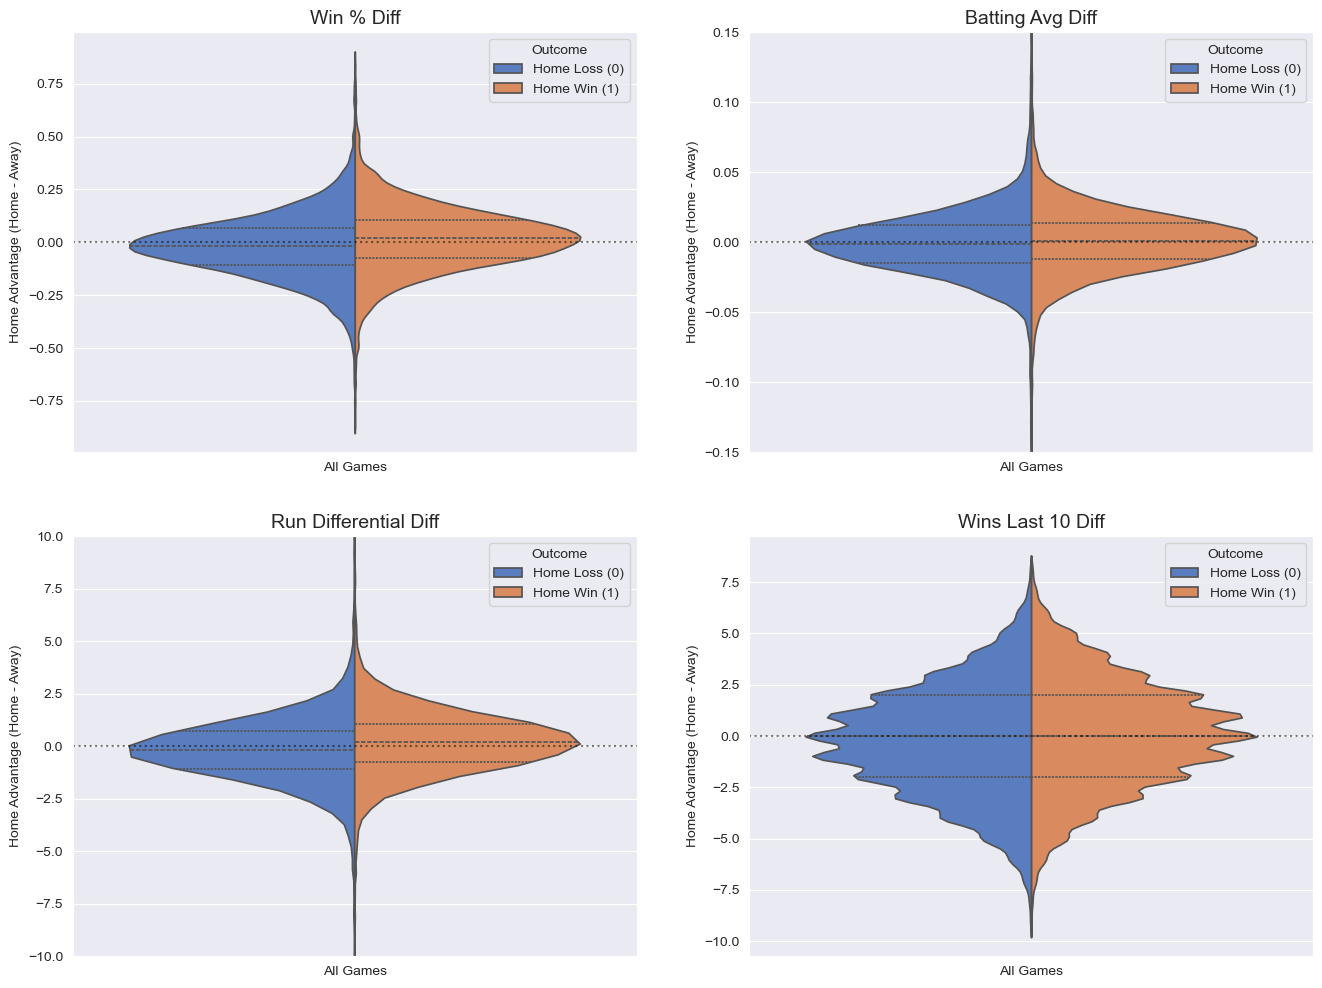

In [317]:
plot_df = df[(df['home_win_pct'] != 0) | (df['away_win_pct'] != 0)].copy()
plot_df['Outcome'] = plot_df['home_win'].map({0: 'Home Loss (0)', 1: 'Home Win (1)'})
plot_df['Dummy'] = "All Games"

# 5. Setup Figure and Features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

features_list = [
    ('diff_win_pct', 'Win % Diff'),
    ('diff_avg', 'Batting Avg Diff'),
    ('diff_run_diff', 'Run Differential Diff'),
    ('diff_wins_last_10', 'Wins Last 10 Diff')
]

# 6. Plotting Loop with Custom Filters/Limits
for i, (col, title) in enumerate(features_list):
    ax = axes[i//2, i%2]

    current_df = plot_df
    y_lims = None

    # Custom Filtering for Win %
    if col == 'diff_win_pct':
        # Disregard any diff win % that is -1 or 1
        current_df = plot_df[(plot_df[col] != -1) & (plot_df[col] != 1)].copy()

    # Custom Axis Limits
    elif col == 'diff_run_diff':
        y_lims = (-10, 10) # Run differential plot from -10 to 10

    elif col == 'diff_avg':
        y_lims = (-0.15, 0.15) # Batting average -.15 to .15

    sns.violinplot(
        data=current_df, x='Dummy', y=col, hue='Outcome',
        split=True, inner='quartile', palette='muted', ax=ax
    )

    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Home Advantage (Home - Away)')
    ax.set_xlabel('')
    ax.axhline(0, color='black', linestyle=':', alpha=0.5)

    if y_lims:
        ax.set_ylim(y_lims)

These show that a lot of the time, teams are very evenly matched, though when the home team wins, they often have a slight edge in the given differential in all of these categories.

 ## Correlation Heatmap

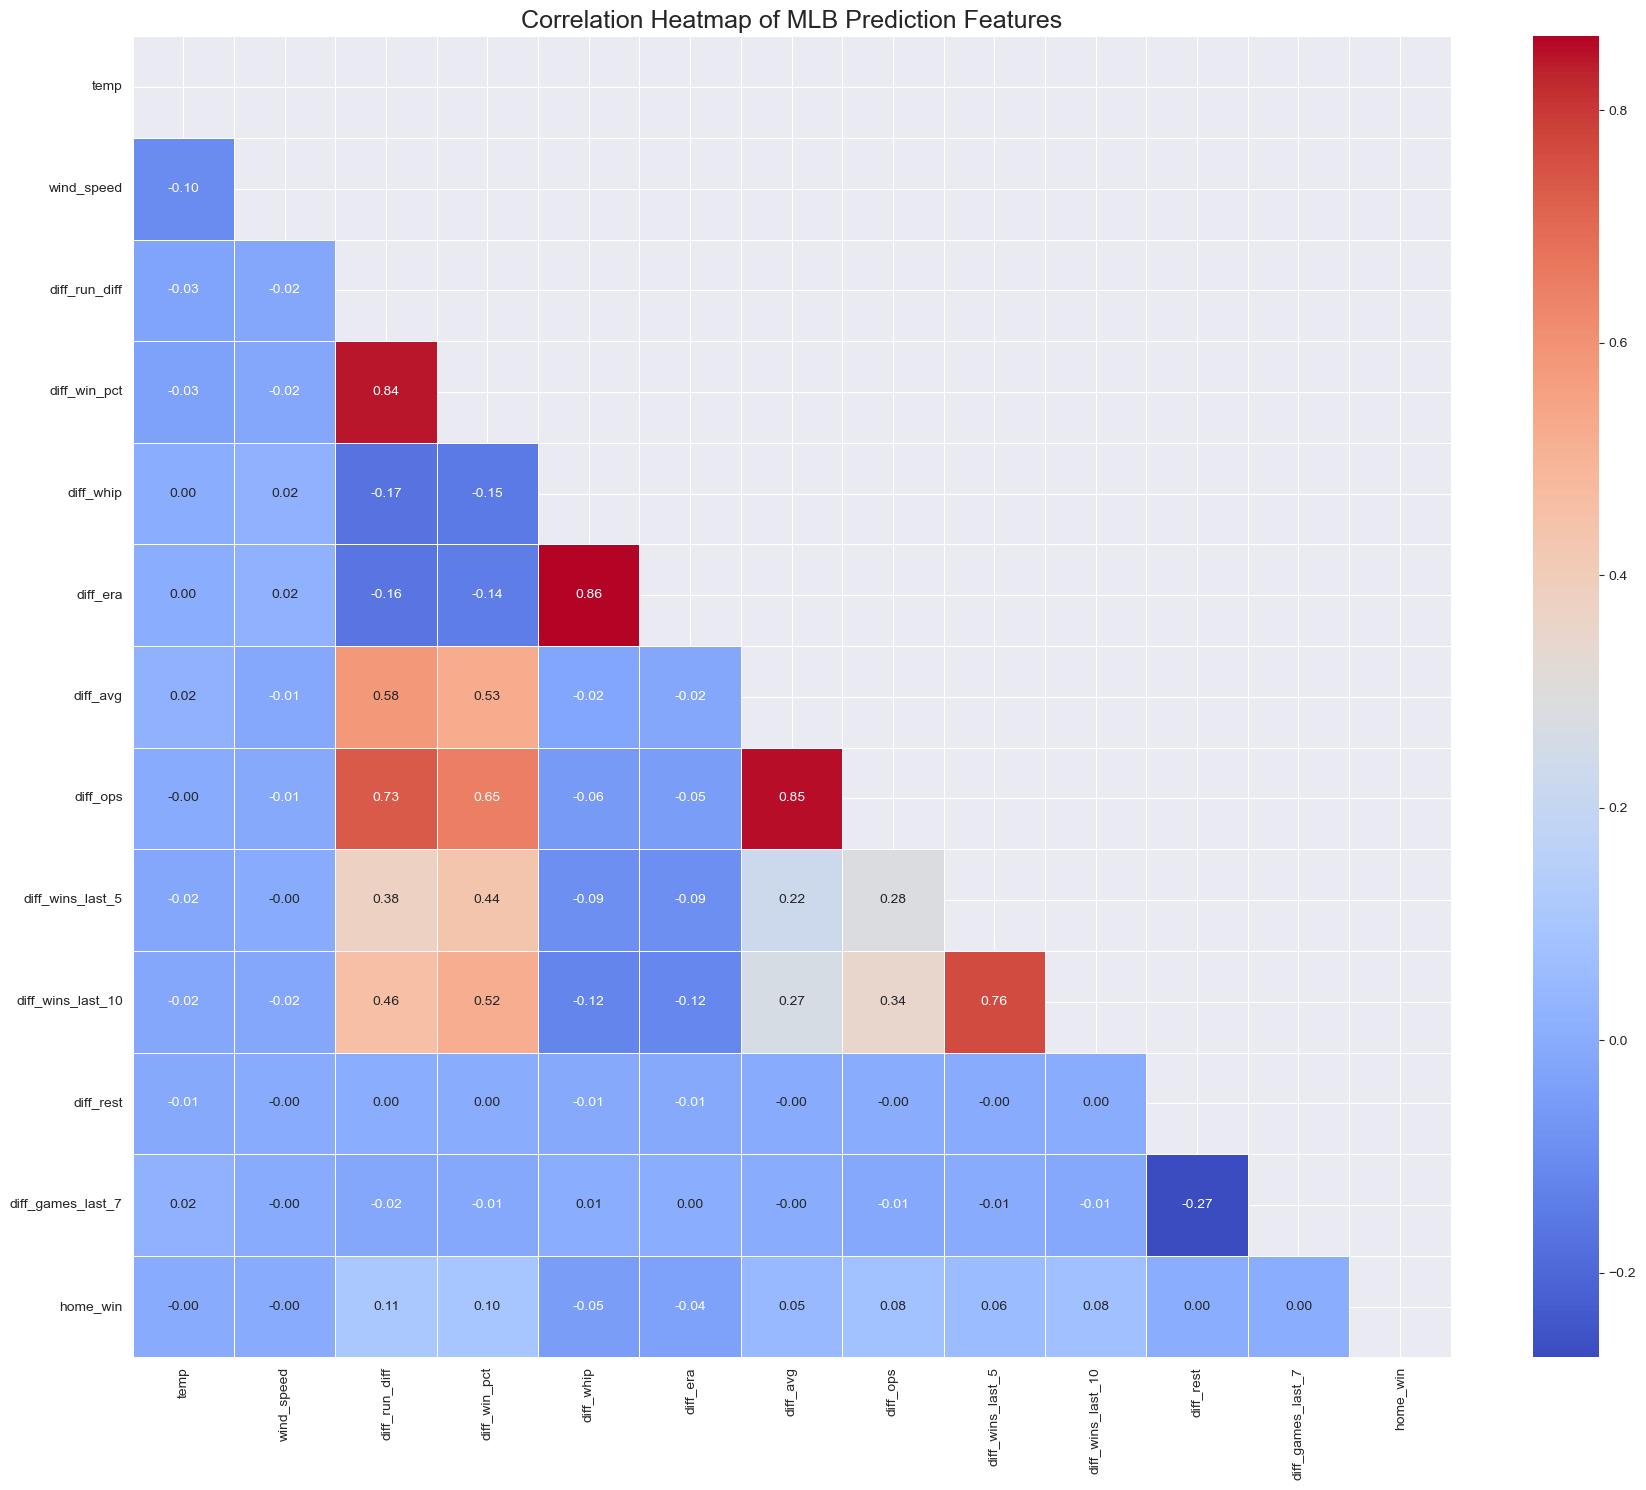

In [318]:
numeric_features = [
    'temp', 
    'wind_speed', 
    'diff_run_diff', 'diff_win_pct',
    'diff_whip', 'diff_era', 'diff_avg', 'diff_ops',
    'diff_wins_last_5', 'diff_wins_last_10',
    'diff_rest', 'diff_games_last_7',
    'home_win'
]

corr_matrix = df[numeric_features].corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(18, 15))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    mask=mask,               # apply the mask to hide the upper half
    linewidths=.5
)

plt.title('Correlation Heatmap of MLB Prediction Features', fontsize=18)
plt.tight_layout()
plt.show()

### Changes/Decisions Made
- Create new features for the difference between two features. Difference in run differential, win percentage, OPS, AVG, ERA, WHIP, rest days, and games in last 7 days. Also momentum statistics like wins in the last 5 or 10 games.
- Would drop diff win %, diff ERA, diff avg, diff OPS to have better features for models like Logistic Regression that need to have the least amount of multicollinearity to provide a good result.

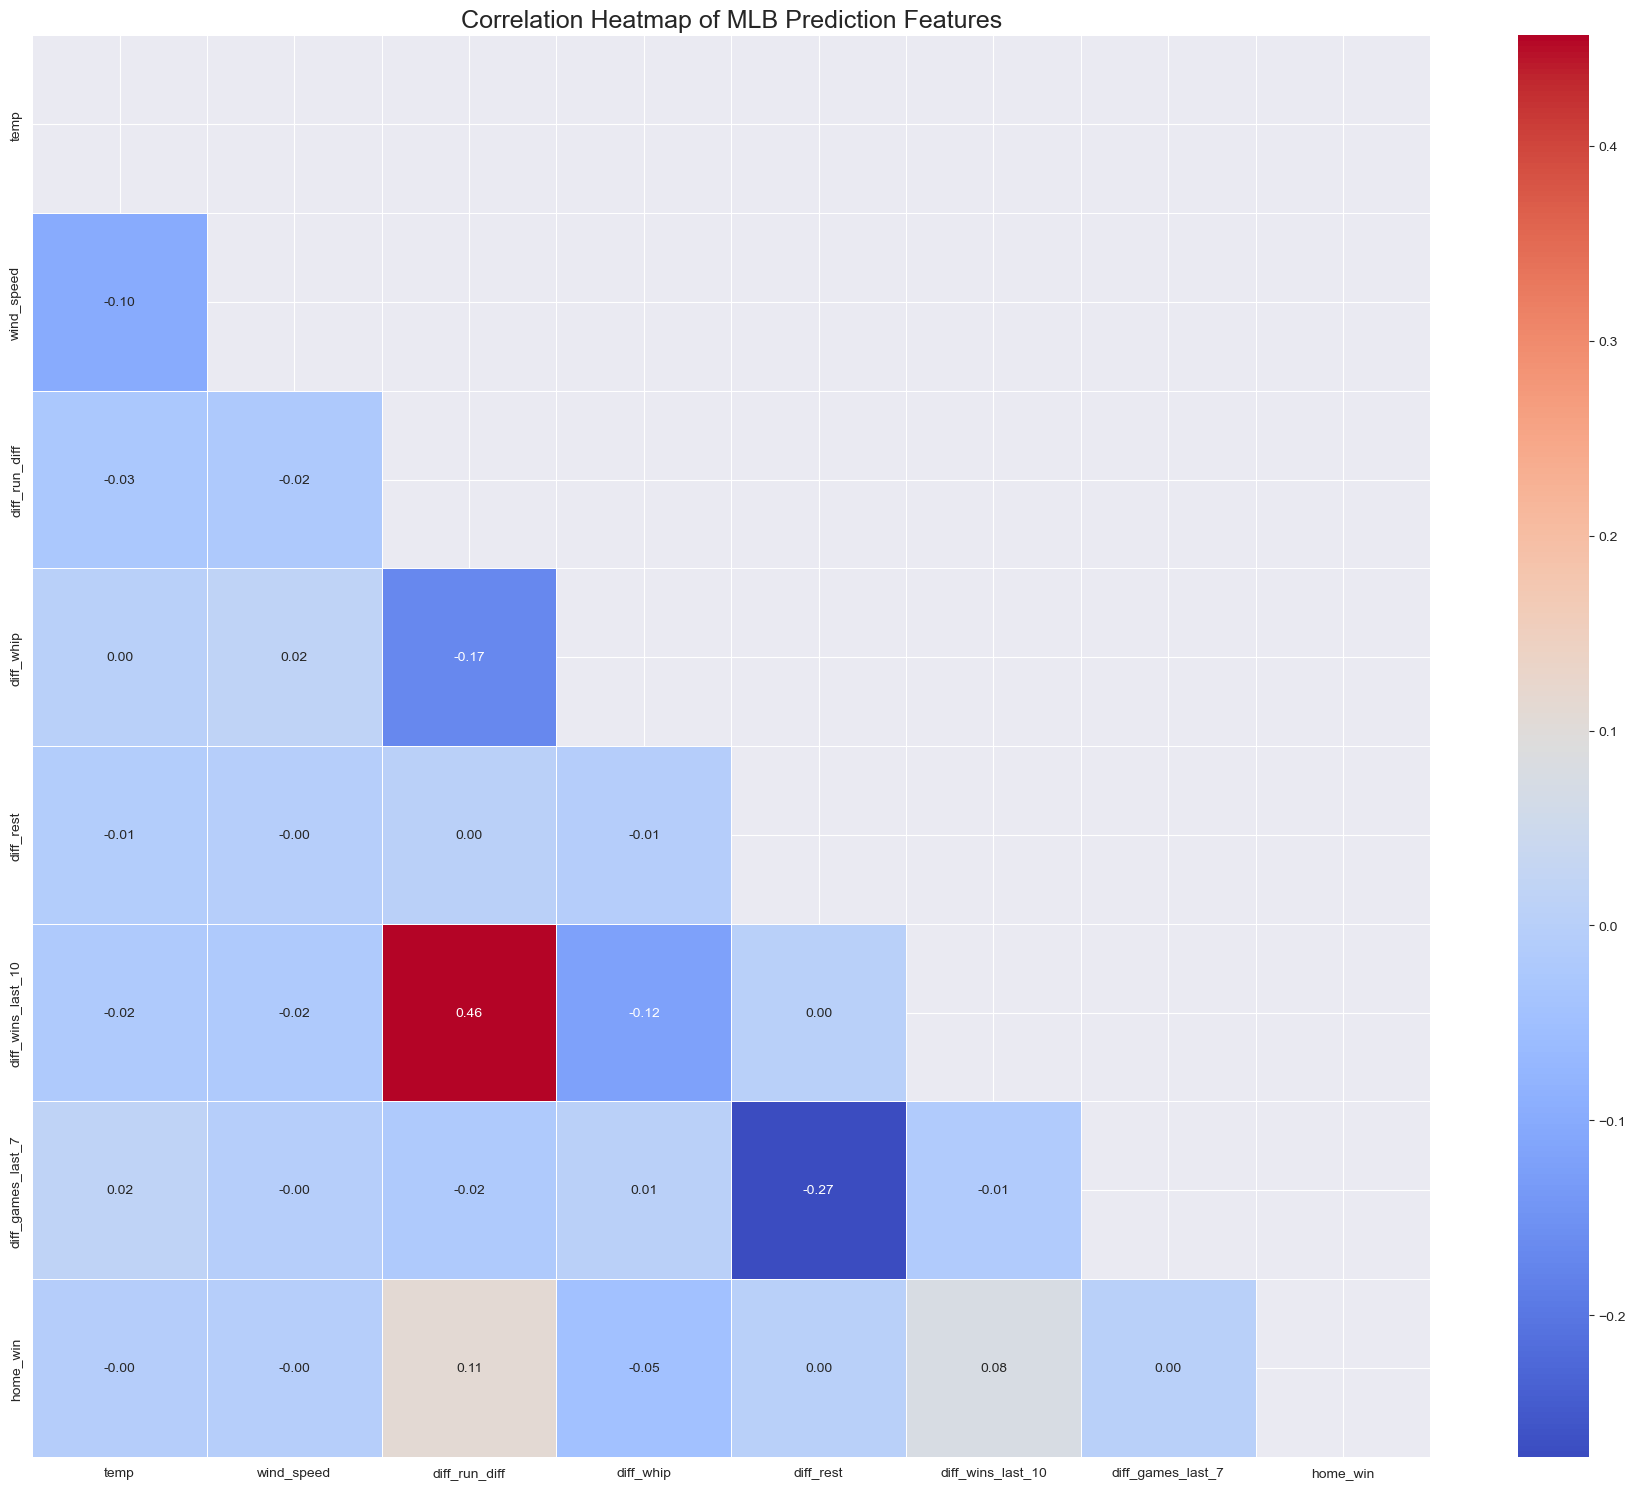

In [319]:
log_reg_features = [
    'temp',
    'wind_speed',
    'diff_run_diff',
    'diff_whip',
    'diff_rest',
    'diff_wins_last_10',
    'diff_games_last_7',
    'home_win'
]

corr_matrix = df[log_reg_features].corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(18, 15))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    mask=mask,               # apply mask to hide the upper half
    linewidths=.5
)

plt.title('Correlation Heatmap of MLB Prediction Features', fontsize=18)
plt.tight_layout()
plt.show()

### Heatmap Analysis
        
#### Predictive Power:
- Difference in Run Differential shows the biggest impact on a home win. (0.11)
- Diff. in Win % shows a large impact, however, is heavily correlated to diff. in Run Differential. (0.10)
- Diff. in OPS and Diff. in Wins - Last 10 Games (0.08)

#### Multicollinearity
- Many of these variables are correlated, like the two pitching stats (ERA, WHIP) and the two hitting stats (average, OPS). 
- Also, schedule-based features (wins in last 5/10 games, days of rest) have heavy correlation, as expected.
- Prior to adding "difference"-based features, the home/away versions had high correlation.

## Conditions

In [320]:
df['condition'].value_counts()

condition
Partly Cloudy    7841
Clear            5111
Cloudy           3966
Roof Closed      3351
Sunny            2778
Overcast         1453
Dome              804
Drizzle           139
Rain              125
Snow                4
Name: count, dtype: int64

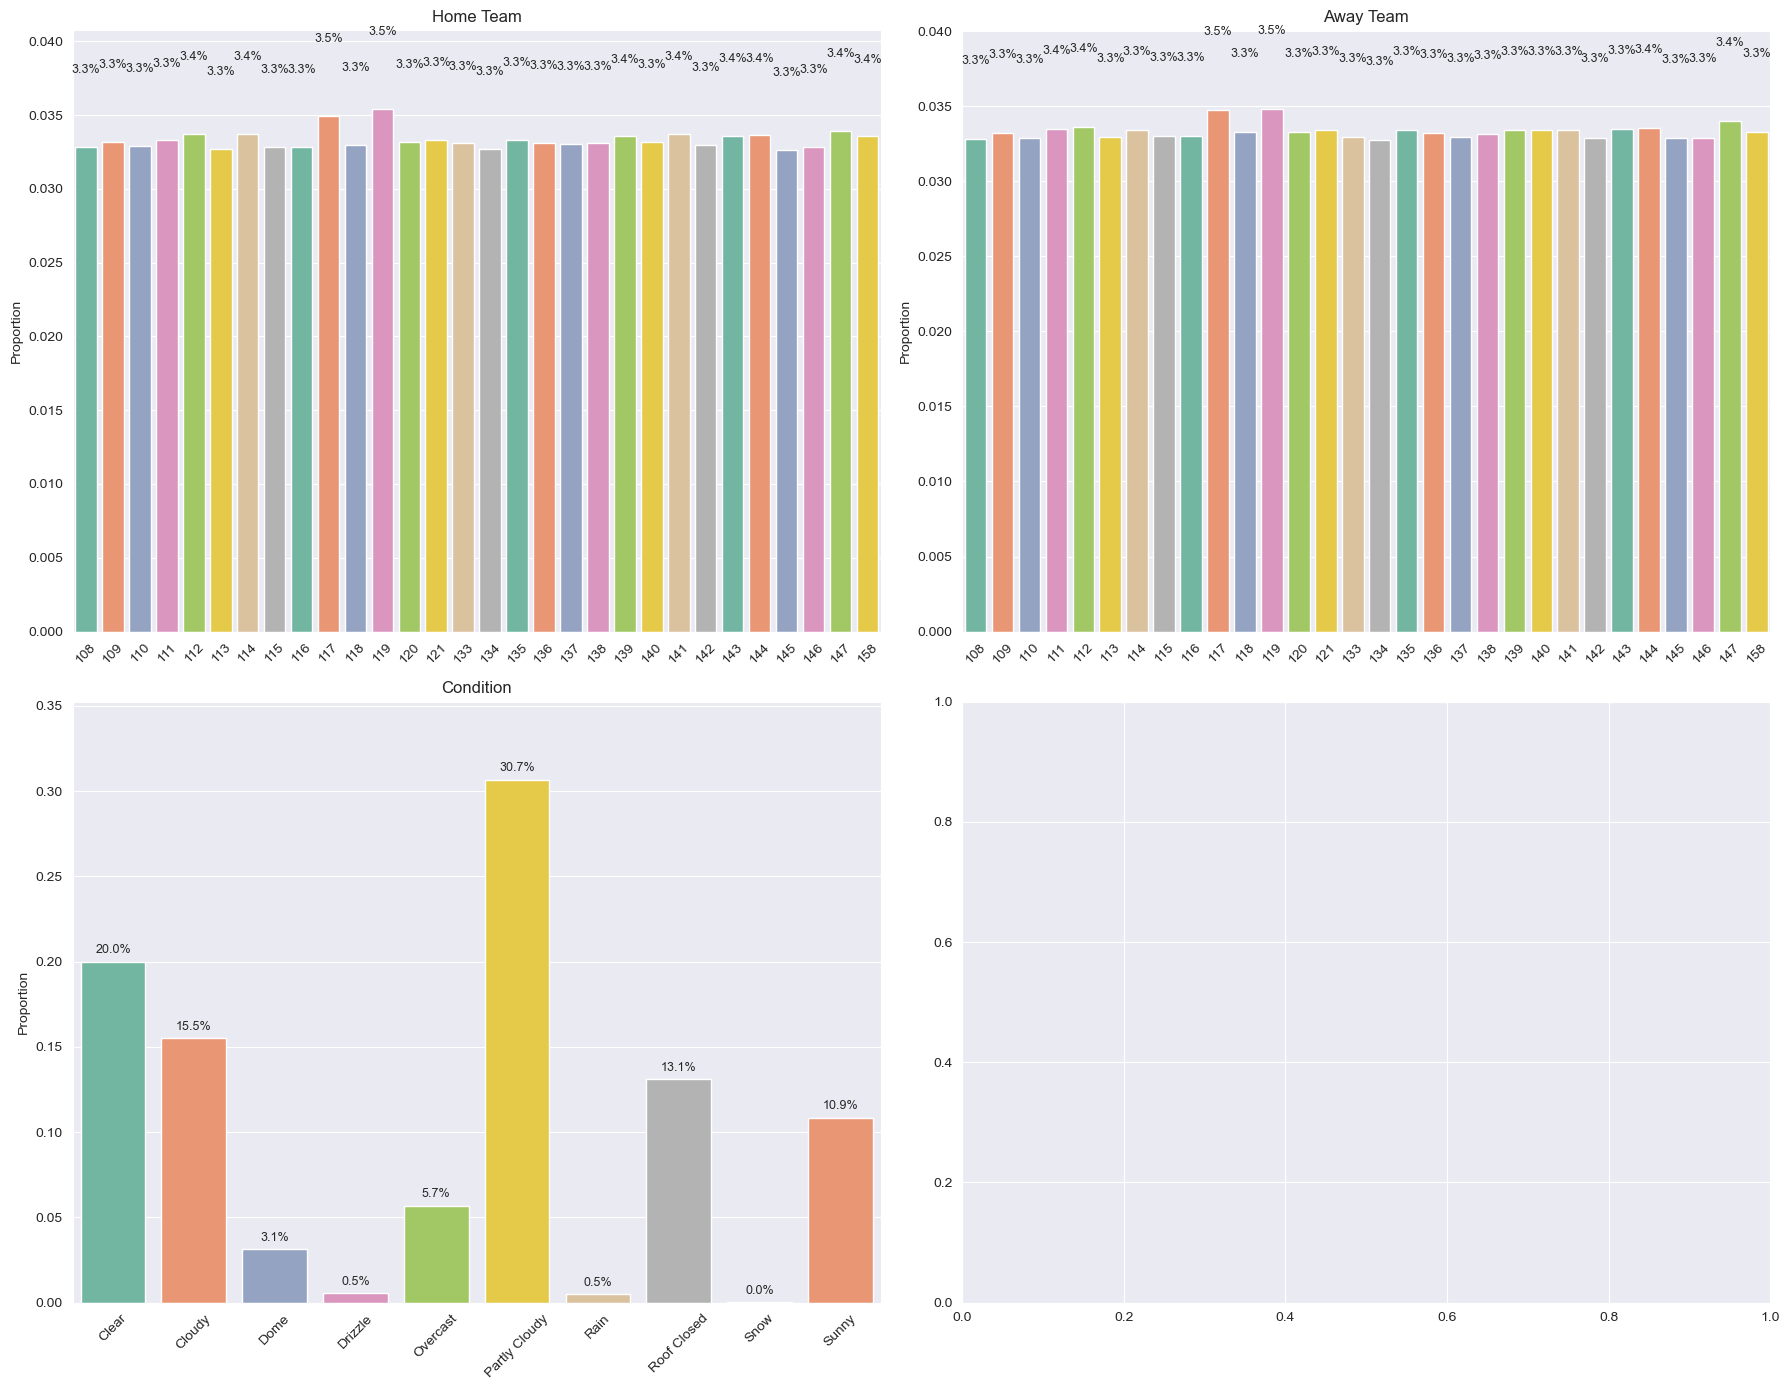

In [321]:
# ANSWER
categorical_cols = df.select_dtypes(include=["category"])
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    prop = df[col].value_counts(normalize=True).sort_index()

    sns.barplot(
        x=prop.index,
        y=prop.values,
        hue=prop.index,
        palette="Set2",
        legend=False,
        ax=ax
    )

    # Annotate percentages above bars
    for j, v in enumerate(prop.values):
        ax.text(j, v + 0.005, f"{v*100:.1f}%", ha='center', fontsize=9)

    ax.set_title(col.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel('Proportion')
    ax.set_xlabel('')
    ax.set_ylim(0, max(prop.values) * 1.15)  # add a bit of headroom
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Teams are evenly weighted, so no imbalance in that. Most of the venues are the usual MLB stadiums, however, there has been some change in stadiums and a few special events outside of the typical 30 MLB stadiums. 60% of the games are in good weather (sunny, clear, or partly cloudy). 20% are in a gloomy setting and about 1% have precipitation. About 15% of games are played in an indoor setting. 

In [322]:
# Win rate by weather condition
weather_impact = df.groupby('condition', observed=True).agg({
    'home_win': ['mean', 'count'],
    'temp': 'mean',
    'wind_speed': 'mean'
}).round(3)
weather_impact.columns = ['Home Win Rate', 'Games', 'Avg Temp', 'Avg Wind']
weather_impact.sort_values('Home Win Rate', ascending=False)

,Home Win Rate,Games,Avg Temp,Avg Wind
condition,,,,
Dome,0.565,804,71.915,0.000
Rain,0.560,125,64.288,8.208
Sunny,0.544,2778,75.132,8.461
Cloudy,0.538,3966,69.808,8.470
Roof Closed,0.537,3351,72.515,0.082
Clear,0.535,5111,75.777,8.318
Partly Cloudy,0.526,7841,75.494,8.568
Overcast,0.514,1453,66.972,8.426
Drizzle,0.475,139,62.007,9.216


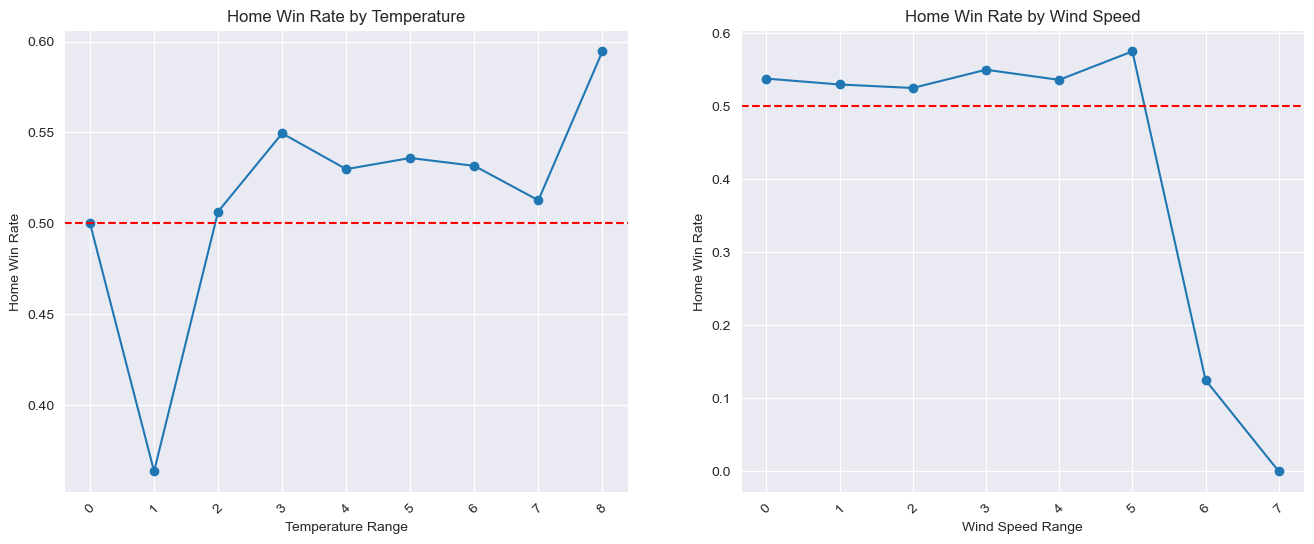

In [323]:
# Temperature effect
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Temp vs Home Win
temp_bins = pd.cut(df['temp'], bins=10)
temp_win_rate = df.groupby(temp_bins, observed=True)['home_win'].mean()
axes[0].plot(range(len(temp_win_rate)), temp_win_rate.values, marker='o')
axes[0].axhline(0.5, color='red', linestyle='--')
axes[0].set_title('Home Win Rate by Temperature')
axes[0].set_xlabel('Temperature Range')
axes[0].set_ylabel('Home Win Rate')
axes[0].tick_params(axis='x', rotation=45)

# Wind vs Home Win
wind_bins = pd.cut(df['wind_speed'], bins=8)
wind_win_rate = df.groupby(wind_bins, observed=True)['home_win'].mean()
axes[1].plot(range(len(wind_win_rate)), wind_win_rate.values, marker='o')
axes[1].axhline(0.5, color='red', linestyle='--')
axes[1].set_title('Home Win Rate by Wind Speed')
axes[1].set_xlabel('Wind Speed Range')
axes[1].set_ylabel('Home Win Rate')
axes[1].tick_params(axis='x', rotation=45)

plt.show()

## Venue

In [324]:
df['venue_id'].value_counts()

venue_id
22      900
2392    887
17      866
3313    866
5       861
32      860
2680    860
2681    859
3289    852
3       850
3309    850
15      849
2395    848
3312    843
7       842
2       841
680     841
1       840
2889    840
2394    838
19      838
31      837
4       834
4169    832
2602    831
14      788
12      769
10      763
4705    693
5325    457
13      408
16      160
2523     81
2529     81
2756     49
2536     21
2735      8
2701      7
5381      6
5340      4
5150      2
2397      2
5445      2
2535      2
5365      1
3949      1
5010      1
6130      1
Name: count, dtype: int64

## Temporal Analysis

In [325]:
# Win rate over time
df_temporal = df.groupby(df['date'].dt.year).agg({
    'home_win': ['mean', 'count']
}).round(3)
df_temporal.columns = ['Home Win Rate', 'Games Played']
df_temporal

,Home Win Rate,Games Played
date,,
2015,0.542,2461
2016,0.530,2456
2017,0.542,2466
2018,0.527,2459
2019,0.528,2456
2020,0.551,949
2021,0.541,2459
2022,0.534,2461
2023,0.519,2468


In [326]:
df['month'] = df['date'].dt.month
monthly_stats = df.groupby('month').agg({
    'home_win': ['mean', 'count']
})
monthly_stats.columns = ['win_rate', 'game_count']
monthly_stats.rename(columns={'win_rate': 'Home Win Rate', 'game_count': 'Games Played'})

,Home Win Rate,Games Played
month,,
3,0.512931,232
4,0.525176,3694
5,0.533381,4164
6,0.538653,4010
7,0.539124,3834
8,0.534396,4579
9,0.527405,4397
10,0.557604,651
11,0.181818,11


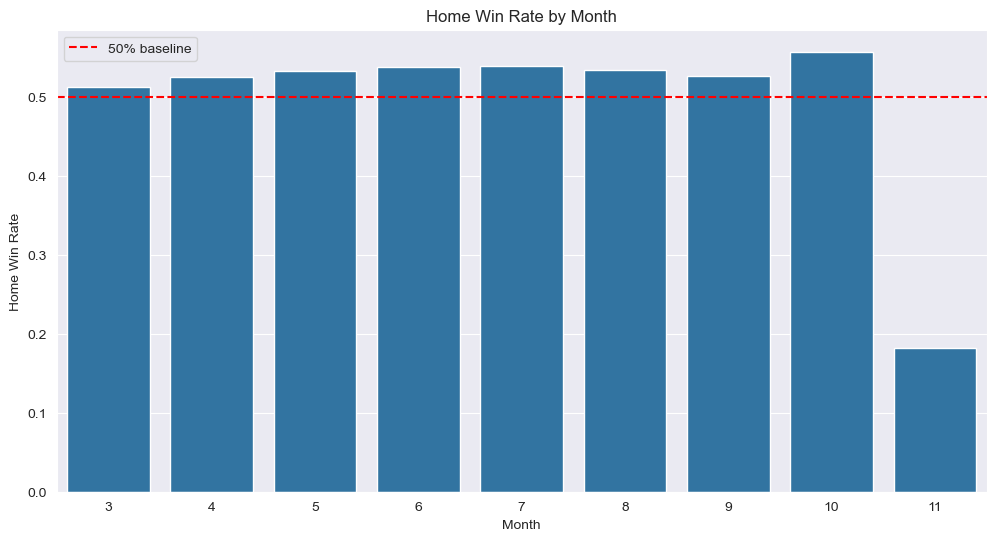

In [327]:
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_stats.index, y=monthly_stats['win_rate'])
plt.axhline(0.5, color='red', linestyle='--', label='50% baseline')
plt.title('Home Win Rate by Month')
plt.xlabel('Month')
plt.ylabel('Home Win Rate')
plt.legend()
plt.show()

It is interesting how the home team win % bumps in October (Playoffs). Very cool to see the home-field advantage actually show, granted there is a smaller sample size. There are very few games played in November, so the win % gets a little weird.

## Park Factors

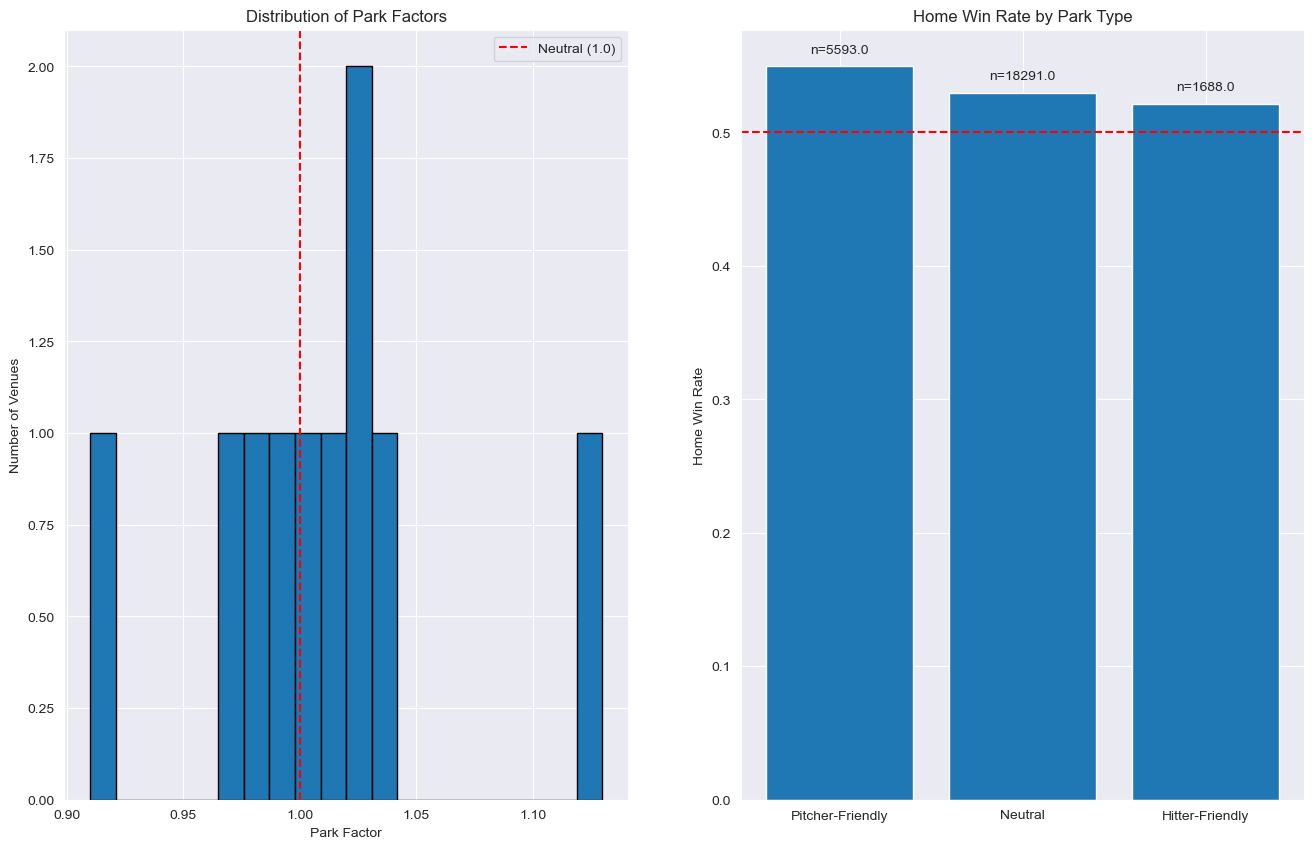

In [328]:
# Analyze park factor distribution and impact
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Distribution of park factors
axes[0].hist(df['park_factor'].unique(), bins=20, edgecolor='black')
axes[0].axvline(1.0, color='red', linestyle='--', label='Neutral (1.0)')
axes[0].set_title('Distribution of Park Factors')
axes[0].set_xlabel('Park Factor')
axes[0].set_ylabel('Number of Venues')
axes[0].legend()

# Home win rate by park factor category
df['park_category'] = pd.cut(df['park_factor'],
                             bins=[0, 0.97, 1.03, 1.20],
                             labels=['Pitcher-Friendly', 'Neutral', 'Hitter-Friendly'])
park_wins = df.groupby('park_category', observed=True)['home_win'].agg(['mean', 'count'])

axes[1].bar(range(len(park_wins)), park_wins['mean'])
axes[1].set_xticks(range(len(park_wins)))
axes[1].set_xticklabels(park_wins.index)
axes[1].axhline(0.5, color='red', linestyle='--')
axes[1].set_title('Home Win Rate by Park Type')
axes[1].set_ylabel('Home Win Rate')

# Add counts as text
for i, (idx, row) in enumerate(park_wins.iterrows()):
    axes[1].text(i, row['mean'] + 0.01, f"n={row['count']}", ha='center')

plt.show()

From the plot on the left, we can see that there are more parks on the "hitter-friendly" side of the plot. From the plot on the left, we see that the home team is more likely to win in a "pitcher-friendly" park rather than a neutral or "hitter-friendly" park.

## Fatigue

In [333]:
# Games in last 7 days impact
games_fatigue = df.groupby('diff_games_last_7')['home_win'].agg(['mean', 'count'])
games_fatigue

,mean,count
diff_games_last_7,,
-5,0.333333,6
-4,0.500000,14
-3,0.392157,51
-2,0.545299,585
-1,0.539341,5249
0,0.528277,13792
1,0.537418,5305
2,0.572254,519
3,0.513514,37


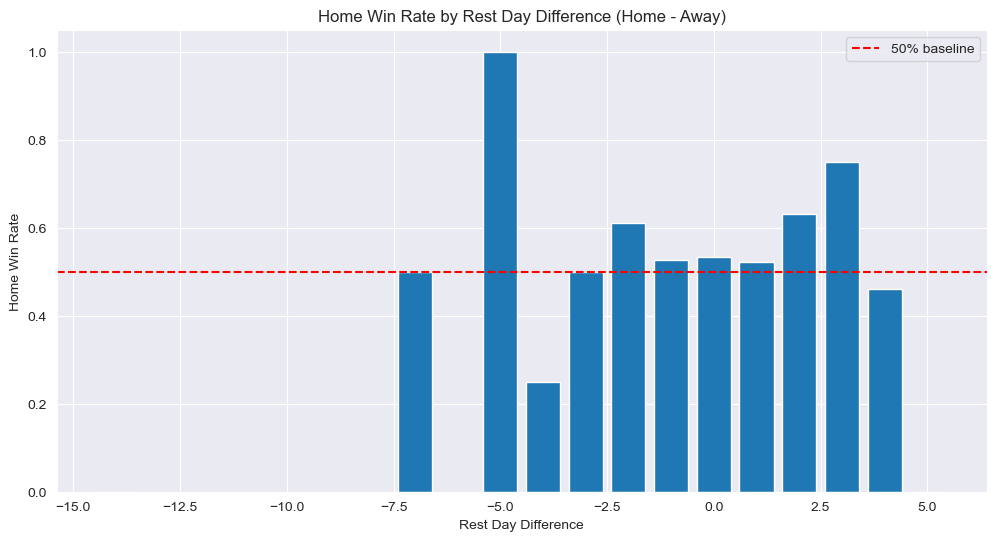

In [337]:
# Rest impact
rest_analysis = df.groupby('diff_rest').agg({
    'home_win': ['mean', 'count']
}).round(3)
rest_analysis.columns = ['Home Win Rate', 'Games']

plt.figure(figsize=(12, 6))
plt.bar(rest_analysis.index, rest_analysis['Home Win Rate'])
plt.axhline(0.5, color='red', linestyle='--', label='50% baseline')
plt.title('Home Win Rate by Rest Day Difference (Home - Away)')
plt.xlabel('Rest Day Difference')
plt.ylabel('Home Win Rate')
plt.legend()
plt.show()

The home team often does better when on longer rest, which makes sense during the long, grueling season. However, there is a very limited sample space on the tails of the distribution, and is tightly compacted at 0.

# Modeling Approach

## Problem Type
This is a **binary classification problem** - predicting whether the home team wins (1) or loses (0).

## Planned Models

### 1. Baseline Models
- **Logistic Regression**: Simple, interpretable baseline with reduced feature set to avoid multicollinearity

### 2. Tree-Based Models
- **Decision Tree**: Understand feature importance and interactions
- **Random Forest**: Ensemble method to reduce overfitting
- **XGBoost**: Gradient boosting for potentially better performance

### 3. Neural Networks (if time permits)
- Simple feedforward neural network for comparison

## Evaluation Metrics
- **Accuracy**: Primary metric (baseline ~53% from class imbalance)
- **Precision/Recall**: Important for understanding false positive/negative rates
- **ROC-AUC**: Overall model discrimination ability
- **F1-Score**: Balance between precision and recall

## Cross-Validation Strategy
- Time-series split to avoid data leakage (can't use future to predict past)
- 5-fold cross-validation on training set
- Hold out 2024-2025 data as final test set

## Feature Selection Approaches
1. **Correlation-based**: Remove highly correlated features for simpler models
2. **Tree-based importance**: Use Random Forest feature importance
3. **Recursive Feature Elimination**: For linear models

## Expected Challenges

### 1. Slight Class Imbalance (53% home wins)
- May need class weights

### 2. Multicollinearity
- Many features are correlated (win%, run differential, OPS, etc.)
- Will create reduced feature sets for different models

### 3. Time-Based Data Leakage
- Must ensure training doesn't use future information
- Use proper time-series splits

### 4. Limited Signal
- Baseball has inherent randomness
- Best models likely 55-60% accuracy (Vegas lines are ~52-54%)

## Learning Goals
- Understand which factors most influence game outcomes
- Compare performance across different model types
- Build intuition for sports prediction challenges
- Practice time-series validation techniques